# Notebook 02 — Feature Engineering & Signal Design

This notebook transforms raw screener snapshots from DuckDB into the engineered features that power:

- The `RL environment`

- The `backtester`

- The `real-time signal engine`

We use the last 60 days of screener history (loaded in Notebook 01) and layer in pricing, volatility, trend, and liquidity features that help the model understand market conditions.

All work is done locally via DuckDB — `no Polygon calls here`, so we avoid rate limits entirely.

## 0. Notebook parameters

We use the same `LOOKBACK_DAYS` window as Notebook 01 so every table aligns consistently by `run_date`.

This ensures:

- All tickers share the same date index

- Rolling windows are valid

- The RL state vector stays stable across notebooks

## 1. Imports and connect to DuckDB

**What this block does**

- Loads core Python libraries

- Connects to the local DuckDB database created earlier

- Prints the analysis window used for feature engineering

**Why this matters**

Everything downstream — features, bucketing, rolling metrics, RL state representation — depends on having:

- A consistent date index

- Clean merged data

- DuckDB tables that match the expected schema

In [1]:
import duckdb
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, timedelta

# Consistent chart size
plt.rcParams["figure.figsize"] = (10, 6)

# ---- Notebook parameters ----
# Keep this aligned with Notebook 01 so both look at the same history window.
LOOKBACK_DAYS = 180  # you can change this to 30, 90, etc.

today = date.today()
cutoff_date = today - timedelta(days=LOOKBACK_DAYS)

print(f"Using last {LOOKBACK_DAYS} days, from {cutoff_date.isoformat()} to {today.isoformat()}")

Using last 180 days, from 2025-06-07 to 2025-12-04


In [2]:
# Path: notebooks/ -> ../data/volatility_alpha.duckdb
DB_PATH = (Path.cwd().parent / "data" / "volatility_alpha.duckdb").as_posix()

# --- Safe reconnect logic ---
# If a DuckDB connection named `con` already exists, close it first.
if "con" in globals():
    try:
        con.close()  # type: ignore
    except Exception:
        pass

# Open a fresh connection
con = duckdb.connect(DB_PATH)

# Sanity check: list tables
con.sql("SHOW TABLES;").df()

,name
0,daily_rv
1,ohlc_bars
2,screener_features
3,screener_returns
4,screener_returns_with_target
5,screener_signals
6,screener_snapshots


## 2. Load recent screener history

**What we load**

Each row represents one `(run_date, ticker)` pair and includes:

- `last_price`

- `day_pct` (today’s % move)

- `rv20` (20-day realized volatility)

- `edge_score` (composite screener score)

- `volume`

This becomes the `base dataset for feature engineering`.

**Why this matters**

Everything else — volatility buckets, trend signals, liquidity regimes — builds on this clean table.
If this step is wrong, the rest of the pipeline collapses.

In [3]:
query = f"""
SELECT
    run_date,
    ticker,
    last_price,
    day_pct,
    volume,
    rv_20d,
    rv_60d,
    edge_score
FROM screener_snapshots
WHERE run_date >= DATE '{cutoff_date.isoformat()}'
ORDER BY ticker, run_date
"""

df = con.sql(query).df()
df["run_date"] = pd.to_datetime(df["run_date"])

print(df.shape)
df.head()

(1200, 8)


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score
0,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172
1,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793
2,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417
3,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984
4,2025-06-20,AAPL,201.00,2.248448,96813542.0,21.957809,51.277561,10.239858


## 3. Engineer core scalar features

We compute simple, high-signal features:

- `move_vs_rv20` — today's move relative to recent realized volatility

- `big_move_prob` — probability a move is unusually large

- `rv_trend_3d` — short-term change in realized volatility

**Why these help**

These features help the agent understand market context:

- Is volatility expanding or contracting?

- Are returns behaving unusually?

- Is there directional pressure in the underlying?

These become the foundation for timing signals and RL state design.

In [4]:
features = df.copy()

# Guard against division by zero
features["move_vs_rv20"] = features["day_pct"] / features["rv_20d"].replace(0, np.nan)

# Volatility trend: short-term vs longer-term realized vol
features["rv_trend"] = features["rv_20d"] - features["rv_60d"]

features.head()

,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend
0,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172,-0.065912,-30.304458
1,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793,0.046678,-29.807686
2,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417,-0.064804,-29.565606
3,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984,0.022170,-29.462392
4,2025-06-20,AAPL,201.00,2.248448,96813542.0,21.957809,51.277561,10.239858,0.102399,-29.319753


## 4. Add short-term rolling stats (5-day window)

For each ticker, calculates:

- `day_pct_mv_5` — 5-day average % move

- `day_pct_vol_5` — 5-day volatility of daily moves

**Why this matters**

Short-term behavior is crucial for detecting:

- Choppiness

- Breakout conditions

- Regime transitions

These signals help the RL agent differentiate stable trends from noisy environments.

In [5]:
## Rolling Window Features

# Sort to be extra safe
features = features.sort_values(["ticker", "run_date"])

group = features.groupby("ticker", group_keys=False)

features["day_pct_ma_5"] = (
    group["day_pct"]
    .rolling(window=5, min_periods=2)
    .mean()
    .reset_index(level=0, drop=True)
)

features["day_pct_vol_5"] = (
    group["day_pct"]
    .rolling(window=5, min_periods=2)
    .std()
    .reset_index(level=0, drop=True)
)

features.head()


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5
0,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172,-0.065912,-30.304458,NaN,NaN
1,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793,0.046678,-29.807686,-0.188861,1.685263
2,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417,-0.064804,-29.565606,-0.592930,1.381981
3,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984,0.022170,-29.462392,-0.324579,1.249519
4,2025-06-20,AAPL,201.00,2.248448,96813542.0,21.957809,51.277561,10.239858,0.102399,-29.319753,0.190026,1.579578


## 5. Categorise Regimes and Buckets

We convert continuous fields into interpretable discrete buckets:

**Volatility Regimes**

Based on `rv20` quantiles:

- low

- normal

- high

**Edge Buckets**

Based on `edge_score`:

- quiet

- active

- hot

**Liquidity Buckets**

Based on `rolling volume`:

- thin

- normal

- thick

**Why this matters**

RL performs better when states have structured meaning.
These buckets help simplify complex market conditions into categorical signals that the agent can reliably learn from.

In [6]:
## Define Buckets

# --- Vol regime from rv_20d quantiles ---
rv20 = features["rv_20d"].dropna()
if len(rv20) >= 3:
    low_q = rv20.quantile(0.33)
    high_q = rv20.quantile(0.66)
else:
    # Fallback if we don't have enough data yet
    low_q = rv20.min()
    high_q = rv20.max()

def classify_vol(rv):
    if pd.isna(rv):
        return "unknown"
    if rv <= low_q:
        return "low"
    if rv >= high_q:
        return "high"
    return "normal"

features["vol_regime"] = features["rv_20d"].apply(classify_vol)

# --- Edge buckets from edge_score thresholds ---
# Adjust thresholds later once you see more data.
features["edge_bucket"] = pd.cut(
    features["edge_score"],
    bins=[-np.inf, 10, 25, np.inf],
    labels=["quiet", "active", "hot"]
)

# --- Liquidity buckets from volume quantiles ---
vol = features["volume"].dropna()
if len(vol) >= 3:
    v_low = vol.quantile(0.33)
    v_high = vol.quantile(0.66)
else:
    v_low = vol.min()
    v_high = vol.max()

def classify_liquidity(v):
    if pd.isna(v):
        return "unknown"
    if v <= v_low:
        return "thin"
    if v >= v_high:
        return "thick"
    return "normal"

features["liquidity_bucket"] = features["volume"].apply(classify_liquidity)

features[[
    "run_date", "ticker", "rv_20d", "vol_regime",
    "edge_score", "edge_bucket",
    "volume", "liquidity_bucket"
]].head()


,run_date,ticker,rv_20d,vol_regime,edge_score,edge_bucket,volume,liquidity_bucket
0,2025-06-13,AAPL,20.945016,normal,6.591172,quiet,51447349.0,normal
1,2025-06-16,AAPL,21.483382,normal,4.667793,quiet,43020691.0,normal
2,2025-06-17,AAPL,21.620035,normal,6.480417,quiet,38856152.0,normal
3,2025-06-18,AAPL,21.672431,normal,2.216984,quiet,45394689.0,normal
4,2025-06-20,AAPL,21.957809,normal,10.239858,active,96813542.0,thick


## 6. Save Engineered Features to DuckDB

We write a reusable table:

`screener_features`

Columns include:

- `run_date`, `ticker`

- `move_vs_rv20`, `rv_trend_3d`, `day_pct_ma_5`, `day_pct_vol_5`

- `vol_regime`, `edge_bucket`, `liquidity_bucket`

**Why this matters**

This becomes the `master feature store` used by:

- Notebook 03 (regime detection & backtesting prep)

- Notebook 04 (baseline policy generation)

- Notebook 05/06 (RL environment & agent training)

All downstream logic relies on this table being complete and correct.

In [7]:
## Write screener_features table

# Drop/recreate the table so it's always aligned with this notebook logic
con.execute("DROP TABLE IF EXISTS screener_features;")

# Register the DataFrame and create the table from it
con.register("features_df", features)
con.execute("""
    CREATE TABLE screener_features AS
    SELECT * FROM features_df
""")
con.unregister("features_df")

# Quick check
con.sql("SELECT * FROM screener_features LIMIT 5;").df()


,run_date,ticker,last_price,day_pct,volume,rv_20d,rv_60d,edge_score,move_vs_rv20,rv_trend,day_pct_ma_5,day_pct_vol_5,vol_regime,edge_bucket,liquidity_bucket
0,2025-06-13,AAPL,196.45,-1.380522,51447349.0,20.945016,51.249474,6.591172,-0.065912,-30.304458,NaN,NaN,normal,quiet,normal
1,2025-06-16,AAPL,198.42,1.002800,43020691.0,21.483382,51.291068,4.667793,0.046678,-29.807686,-0.188861,1.685263,normal,quiet,normal
2,2025-06-17,AAPL,195.64,-1.401068,38856152.0,21.620035,51.185641,6.480417,-0.064804,-29.565606,-0.592930,1.381981,normal,quiet,normal
3,2025-06-18,AAPL,196.58,0.480474,45394689.0,21.672431,51.134823,2.216984,0.022170,-29.462392,-0.324579,1.249519,normal,quiet,normal
4,2025-06-20,AAPL,201.00,2.248448,96813542.0,21.957809,51.277561,10.239858,0.102399,-29.319753,0.190026,1.579578,normal,active,thick


## 7. Simple EDA on engineered features

We run a few sanity checks:

**Distribution of move_vs_rv20**

Confirms daily moves behave sensibly relative to volatility.

**Cross-tab of vol_regime × edge_bucket**

Confirms bucket definitions make sense together.

**Rolling behavior for a sample ticker**

Validates:

- no anomalies

- rolling windows behave correctly

- engineered features follow expected patterns

If these checks fail, the RL state space would be unreliable.

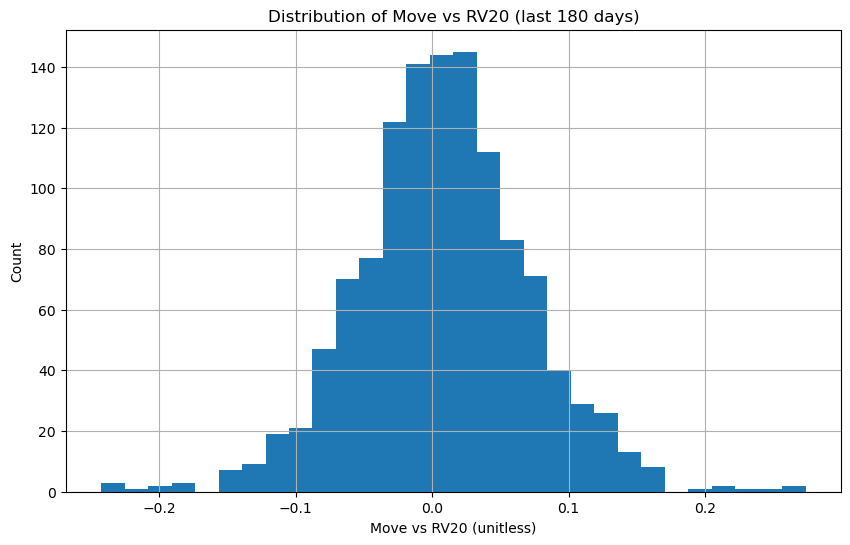

Right now the distribution is thin because we only have a small sample.
As more days accumulate, we expect most values to cluster near 0,
with outliers where today's move is unusually large relative to RV20.


In [9]:
## 7.1 Distribution of move_vs_rv20

clean_mv = features.replace([float("inf"), float("-inf")], np.nan)
clean_mv = clean_mv.dropna(subset=["move_vs_rv20"])

clean_mv["move_vs_rv20"].hist(bins=30)
plt.title(f"Distribution of Move vs RV20 (last {LOOKBACK_DAYS} days)")
plt.xlabel("Move vs RV20 (unitless)")
plt.ylabel("Count")
plt.show()

print("Right now the distribution is thin because we only have a small sample.")
print("As more days accumulate, we expect most values to cluster near 0,")
print("with outliers where today's move is unusually large relative to RV20.")

In [10]:
## 7.2 Vol regime vs edge bucket counts

pivot = con.sql("""
    SELECT
        vol_regime,
        edge_bucket,
        COUNT(*) AS cnt
    FROM screener_features
    GROUP BY vol_regime, edge_bucket
    ORDER BY vol_regime, edge_bucket
""").df()

pivot

,vol_regime,edge_bucket,cnt
0,high,quiet,367
1,high,active,38
2,high,hot,3
3,low,quiet,351
4,low,active,45
5,normal,quiet,347
6,normal,active,49


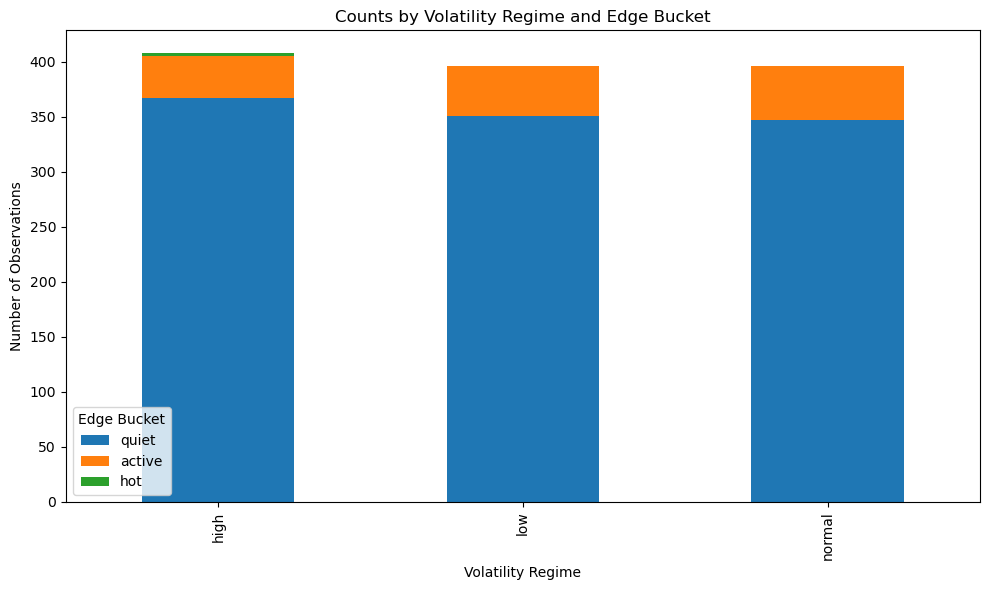

In [11]:
# Plot as a stacked bar chart
if not pivot.empty:
    plot_df = pivot.pivot(index="vol_regime", columns="edge_bucket", values="cnt").fillna(0)

    plot_df.plot(kind="bar", stacked=True)
    plt.title("Counts by Volatility Regime and Edge Bucket")
    plt.xlabel("Volatility Regime")
    plt.ylabel("Number of Observations")
    plt.legend(title="Edge Bucket")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough rows yet to build a regime × edge bucket plot.")

**Reading this plot:**  
This chart shows how often different volatility regimes (`low`/`normal`/`high`)  
coincide with different edge buckets (`quiet`/`active`/`hot`).  
With more history, this will tell us whether high-volatility environments tend  
to produce more “hot” edge days and where most of our potential trades live.

Sample ticker for rolling view: AAPL


,run_date,day_pct,day_pct_ma_5,day_pct_vol_5
0,2025-06-13,-1.380522,NaN,NaN
1,2025-06-16,1.002800,-0.188861,1.685263
2,2025-06-17,-1.401068,-0.592930,1.381981
3,2025-06-18,0.480474,-0.324579,1.249519
4,2025-06-20,2.248448,0.190026,1.579578


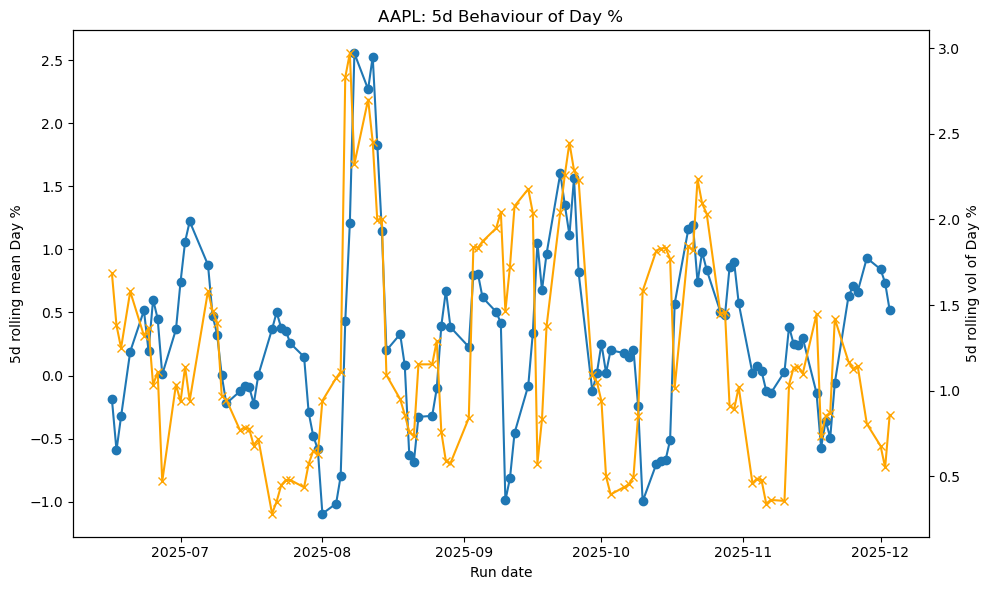

The 5-day rolling mean of Day % captures short-term trend, while the 5-day rolling volatility captures choppiness.
 In a richer dataset, rising mean with falling volatility would point to cleaner trends; rising vol with flat mean would suggest noisy conditions.


In [12]:
# Pick a ticker with the most history in this window
ticker_counts = features["ticker"].value_counts()
if not ticker_counts.empty:
    sample_ticker = ticker_counts.index[0]
    print(f"Sample ticker for rolling view: {sample_ticker}")

    example = (
        features[features["ticker"] == sample_ticker]
        .sort_values("run_date")
        [["run_date", "day_pct", "day_pct_ma_5", "day_pct_vol_5"]]
        .copy()
    )

    display(example.head())

    if len(example) >= 3:
        fig, ax1 = plt.subplots()

        ax1.plot(example["run_date"], example["day_pct_ma_5"],
                 label="5d rolling mean of Day %", marker="o")
        ax1.set_ylabel("5d rolling mean Day %")
        ax1.set_xlabel("Run date")

        ax2 = ax1.twinx()
        ax2.plot(example["run_date"], example["day_pct_vol_5"], # type: ignore
                 label="5d rolling vol of Day %", color="orange", marker="x")
        ax2.set_ylabel("5d rolling vol of Day %")

        plt.title(f"{sample_ticker}: 5d Behaviour of Day %")
        fig.tight_layout()
        plt.show()

        print(
            "The 5-day rolling mean of Day % captures short-term trend, while the",
            "5-day rolling volatility captures choppiness.\n",
            "In a richer dataset, rising mean with falling volatility would point",
            "to cleaner trends; rising vol with flat mean would suggest noisy conditions.",
        )
    else:
        print("Not enough history yet to plot a meaningful rolling window.")
else:
    print("No tickers found in the features table.")


## 8. How these features feed RL & backtesting

After engineering features, each `(run_date, ticker)` now has a complete state vector, e.g.:

Example RL state vector:

`state = [
    move_vs_rv20, rv_trend_3d, 
    day_pct_ma_5, day_pct_vol_5,
    one_hot(vol_regime),
    one_hot(edge_bucket),
    one_hot(liquidity_bucket)
]`

---

**Why this matters**

This state representation defines what the agent “sees” at each decision step.
It is also the basis for rule-based backtesting before RL.

This is the **core foundation of the Volatility Alpha Engine**.

In [14]:
con.close()